In [1]:
import sys;sys.version

'3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

## Early Sound Experiments

We all have our own ways of getting into subjects.
I have never been paticularly musical, but have always
enjoyed music, and so when I came across the Python
`sounddevice` package I realised I had finally found
a way to allow the development of a practical
understanding of sound, and hence possibly music.

The first thing to do was write code to produce a basic sine wave,
which proved relatively easy to do.

To avoid complicating the mathematics to no good purpose, we will
often assume that the initial signal phase is zero.

In [2]:
%matplotlib inline

In [3]:
import sounddevice as sd
from math import pi
import numpy as np
import matplotlib.pyplot as plt

In [4]:
f = 400  # A above middle C
x = np.linspace(0, f*2*pi, 48000)
sine_wave = np.sin(x)
sd.play(sine_wave)
sd.wait()
sd.stop()

### Amplitude Modulation

Amplitude modulation uses relatively simple arithmetic to make the sound's loudness vary.
I initially chose to modulate the basic frequency with a signal low enough to hear.
As the modulation frequency rises the modulation effect becomes less clearly heard and
we instead perceive separate tones.

For a carrier of amplitude $A$ with a frequency of $f_c$, modulated by a signal of
frequency $f_m$ with modulation depth $0 <= \beta <= 1$, the instantaneous signal
amplitude $S_t$ at time $t$ is

$S_t = (A \cos 2\pi f_c t) (\beta \cos 2\pi f_m t))$

In [5]:
for f in 440, 220, 110, 55:
    modulation = np.sin(x/f)
    mod_sig = modulation * sine_wave
    sd.play(mod_sig)
    sd.wait()
    sd.stop()

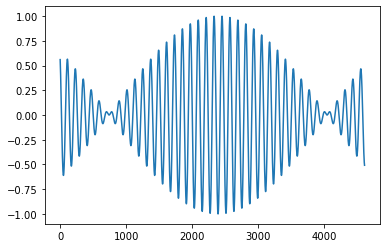

In [6]:
plt.plot(mod_sig[512*5:512*14])

### Frequency modulation

For a carrier of amplitude $A$ with a frequency of $f_c$,
modulated by a signal of frequency $f_m$ and maximum deviation $\beta$,
the instantaneous signal amplitude $S$ at time $t$ 

$S\{t\} = A \cos ({ 2\pi f_c t} + \beta \sin { 2 \pi f_m t})$

In [7]:
fc = 440
omegac = 2*pi*fc
fm = 44
omegam = 2 * pi * fm
A = 1
t = np.linspace(0, 1, 48000)  # "One second in time ..."
s = A * np.cos(omegac*t + 4*np.sin(omegam*t))
sd.play(s)
sd.wait()
sd.stop()

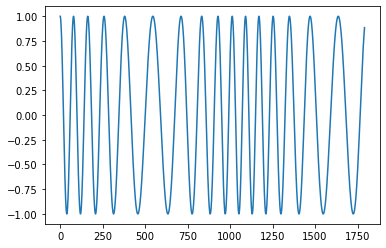

In [8]:
plt.plot(s[:256*7])

### The Even-Tempered Scale

Getting a little bit tired of all the `sd.play .. sd.wait ... sd.stop` stuff,
here I worked out how to play an octave (though not in any optimal
way, I simply wanted to ensure the note computations were correct).

You will notice I am generating over a second's worth of sound (since the
default sampling rate is 44.1 kHz) for each note but, to minimise tedium,
only play a fifth of it.

In [9]:
base = 440
octave = [2**(n/12.0) for n in range(13)]
t = np.linspace(0, base*2*pi, 48000)
for note in 0, 2, 4, 5, 7, 9, 11, 12:
    f = octave[note]
    output = np.cos(f*t)
    sd.play((output[:9600]))
    sd.wait()
    sd.stop()

You can query the devices available to you, which is handy if, for example, you want to
offer your users a choice of which device to use.

In [10]:
sd.query_devices()

  0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 Loopback Audio, Core Audio (2 in, 2 out)
> 3 An Imaginary Device, Core Audio (2 in, 0 out)

In [11]:
sd.query_devices()[0]

{'name': 'Built-in Microphone',
 'hostapi': 0,
 'max_input_channels': 2,
 'max_output_channels': 0,
 'default_low_input_latency': 0.0029478458049886623,
 'default_low_output_latency': 0.01,
 'default_high_input_latency': 0.01310657596371882,
 'default_high_output_latency': 0.1,
 'default_samplerate': 44100.0}

You can also query host APIs, whatever they are. I did not bother at this stage to explore further.

In [12]:
sd.query_hostapis()

({'name': 'Core Audio',
  'devices': [0, 1, 2, 3],
  'default_input_device': 3,
  'default_output_device': 1},)

### Using Blocking Streams

The beauty of blocking streams for output is that you simply write the sample
data to the stream and it gets played. The minor complication is that your program
will block if the stream's buffers get full. This need not necessarily be a
compelling disadvantage as long as you can compute your signal from $t$.

Another option might be to write a bunch of components that manipulate one or
more incoming data streams, whose ultimate output(s) is(are) written to (an)
OutputStream(s). I'm not ready to think about architecture until I've played
with the bricks a bit more.

This next cell was just a test to see what range of sample values would give an
audible tone. I wrote three chunks just to verify that the waiting stuff was
no longer necessary when the stream was used as a context manager.

In [13]:
x = np.array(sine_wave*2**30, dtype="int32")

with sd.OutputStream(channels=1, dtype='int32') as stream:
    print(stream.closed, stream.channels, stream.samplerate)
    for i in range(3):
        stream.write(x)

False 1 44100.0


### Towards a Streamed Player

Now we can integrate this streaming technique into an object that plays notes
over the stream. Really we need a proper pipelining architecture, but for
now I'm happy to noodle around with sound generation.

In [14]:
octave = [2**(n/12.0) for n in range(13)]

class Player:
    
    def __init__(self, stream):
        self.stream = stream
        self.rate = stream.samplerate
        self.one_sec = np.linspace(0, base*2*pi, int(self.rate))
        self.range = 2**30

    def play_note(self, f, d):
        s_len = self.rate*d
        t = np.linspace(0, d, s_len)
        samples = (self.range*np.cos(2*pi*f*t)).astype('int32')
        self.stream.write(samples)
        return samples

In [15]:
with sd.OutputStream(channels=1, dtype='int32') as stream:
    p = Player(stream)
    for note in 0, 2, 4, 5, 7, 9, 11, 12:
        s = p.play_note(440*octave[note], 0.15)

With music suitably encoded and more sophistication in the processing pipeline
there is no reason why this code should not play music, but clearly the current
level of sophistication is unsatisfactory. A primary technical consideration is
achieving polyphony - if the hardware has it built in this would be huge, but I
guess that a modern Mac has enough wallop to emulate it in software if necessary.